# Paper sublimation proportion

With physics + Arctic snow code modifications v1 (subli correct v2)

Not really good, we would need to output the blowing snow sublimation rate directly in the model in the future to get a proper estiamtion.

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os

In [2]:
# https://www.w3schools.com/python/python_classes.asp

class Site:
  def __init__(self, name, long_name, location, lat, lon, elevation, period, start, stop, period_used, run):
    self.name = name
    self.long_name = long_name
    self.location = location
    self.lat = lat
    self.lon = lon
    self.elevation = elevation
    self.period = period
    self.start = start
    self.stop = stop
    self.period_used = period_used
    self.run = run

exps = [
    # 'DEF',
    # 'BUG_CORRECT',
    # 'BUG_CORRECT_TSNBT_OP1',
    'BUG_CORRECT_TSNBT_OP1_EZERO',
    # 'PHYS_ALL_SUBLI_CORRECT',
    'PHYS_ALL_SUBLI_v2',
    # 'PHYS_ALL_SUBLI_CORRECT_COMPAC',
    # 'PHYS_ALL_SUBLI_v2_COMPAC_v1',
    # 'PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne', # Best without TVC (COMPACT_2.5)
    # 'PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne', # best with TVC

]

# SnowMIP
# cdp = Site('cdp', 'Col de Porte, France', '45.30°N, 5.77°E', 45.30, 5.77, '1325 m', 
#            '1 October 1994 to 30 September 2014', '1994-10-01', '2014-09-30', slice('1994-10-01', '2014-09-30'), exps)

# rme = Site('rme', 'Reynolds Mountain East, Idaho, USA', '43.19°N, 116.78°W', 43.19, -116.78, '2060 m', 
#            '1 October 1988 to 30 September 2008', '1988-10-01', '2008-09-30', slice('1988-10-01', '2008-09-30'), exps)

snb = Site('snb', 'Senator Beck, Colorado, US', '37.91°N, 107.73°W', 37.91, -107.73, '3714 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

# swa = Site('swa', 'Swamp Angel, Colorado, USA', '37.91°N, 107.71°W', 37.91, -107.71, '3371 m', 
#            '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

# sap = Site('sap', 'Sapporo, Japan', '43.08°N, 141.34°E', 43.08, 141.34, '15 m', 
#            '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

# sod = Site('sod', 'Sodankylä, Finland', '67.37°N, 26.63°E', 67.37, 26.63, '179 m', 
#            '1 October 2007 to 30 September 2014', '2007-10-01', '2014-09-30', slice('2007-10-01', '2014-09-30'), exps)

# wfj = Site('wfj', 'Weissfluhjoch, Switzerland', '46.83°N, 9.81°E', 46.83, 9.81, '2540 m', 
#            '1 September 1996 to 31 August 2016', '1996-10-01', '2016-08-31', slice('1996-10-01', '2016-08-31'), exps)

# Arctic 
byl = Site('byl', 'Bylot Island, Canadian high Arctic', '73.15°N, 80.00°W', 73.15, -80.00, '25 m', 
           '11 July 2013 to 25 June 2019', '2013-07-11', '2019-06-25', slice('2014-07-11', '2019-06-25'), 
           [
               # 'peat_DEF',
               # 'peat_BUG_CORRECT',
               # 'peat_BUG_CORRECT_TSNBT_OP1',
               'peat_BUG_CORRECT_TSNBT_OP1_EZERO',
               # 'peat_PHYS_ALL_SUBLI_CORRECT',
               'peat_PHYS_ALL_SUBLI_v2',
               # 'peat_PHYS_ALL_SUBLI_CORRECT_COMPAC',
               # 'peat_PHYS_ALL_SUBLI_v2_COMPAC_v1',
               # 'peat_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne',
               # 'peat_PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne',
           ])

umt = Site('umt', 'Umiujaq TUNDRA, northeastern Canada', '56.55877°N, 76.48234°W', 56.55877, -76.48234, '132 m', 
           '28 Sept 2012 to 15 October 2021', '2012-09-28', '2021-10-15', slice('2016-09-01', '2021-08-31'), 
           [
               # 'DEF_correct_SH',
               # 'BUG_CORRECT',
               # 'BUG_CORRECT_TSNBT_OP1',
               'BUG_CORRECT_TSNBT_OP1_EZERO_correct_SH',
               # 'PHYS_ALL_SUBLI_CORRECT',
               'PHYS_ALL_SUBLI_v2_correct_SH',
               # 'PHYS_ALL_SUBLI_CORRECT_COMPAC',
               # 'PHYS_ALL_SUBLI_v2_COMPAC_v1_correct_SH',
               # 'PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne_correct_SH',
               # 'PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne_correct_SH',
           ])


tvc = Site('tvc', 'Trail Valley Creak, northwestern Canada', '68.74617°N, 133.50171°W', 68.74617, -133.50171, '85 m', 
           '01 Oct 2017 to 30 Sept 2019', '2017-10-01', '2019-09-30', slice('2017-10-01', '2019-09-30'), 
           [
               # '1peat_2xSnowf_DEF_correct_SH',
               # '1peat_2xSnowfBUG_CORRECT',
               # '1peat_2xSnowfBUG_CORRECT_TSNBT_OP1',
               '1peat_2xSnowf_BUG_CORRECT_TSNBT_OP1_EZERO_correct_SH',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_CORRECT',
               '1peat_2xSnowf_PHYS_ALL_SUBLI_v2_correct_SH',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_CORRECT_COMPAC',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_v2_COMPAC_v1_correct_SH',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_v2_COMPAC_v1_calonne_correct_SH',
               # '1peat_2xSnowf_PHYS_ALL_SUBLI_v2_COMPAC_2.5_LIM_3.5_calonne_correct_SH',
           ])

# umf = Site('umf', 'Umiujaq FOREST, northeastern Canada', '56.55308°N, 76.47258°W', 56.55308, -76.47258, '82 m', 
#            '26 Nov 2015 to 19 October 2021', '2015-11-26', '2021-10-19', slice('2018-09-01', '2021-08-31'), 
#            ['Ref', 'EZERO'])


In [3]:
# SnowMIP_sites = [cdp, rme, snb, swa, sap, sod, wfj]
SnowMIP_sites = [snb]
# SnowMIP_sites = [cdp, rme, snb, sap, sod, wfj]
SnowArctic_sites = [byl, umt, tvc]

path_SnowMIP = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'
path_SnowArctic = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'
path_Paul = '/home/lalandmi/Dropbox/data/SnowMIP/Paul/CLASS_Results'

ds_d_SnowMIP_list = []
for i, exp in enumerate(exps):
    paths_SnowMIP = [path_SnowMIP+site.name+'/'+'run_'+exp for site in SnowMIP_sites]
    # Change the syntax as the ref run is not necessarily having the same name for all sites
    paths_SnowArctic = [path_SnowArctic+site.name+'/'+'run_'+site.run[i] for site in SnowArctic_sites]
    paths = paths_SnowMIP + paths_SnowArctic
    ds_d_SnowMIP_list.append([xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths])


# ds_d_Paul_list = []
# for site in SnowMIP_sites:
#     df_Paul = pd.read_csv(path_Paul+'/CLASS_sv_REF_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.txt', delim_whitespace=True)
#     df_Paul.index = pd.to_datetime(df_Paul[['year', 'month', 'day', 'hour']]).values
#     df_Paul= df_Paul.drop(columns=['year', 'month', 'day', 'hour'])
#     df_Paul.albsn = df_Paul.albsn.replace({0 : np.nan})
#     df_Paul.albs = df_Paul.albs.replace({0 : np.nan})
#     df_Paul.tsn = df_Paul.tsn.replace({-999 : np.nan})
#     df_Paul.tsns = df_Paul.tsns.replace({-999 : np.nan})
#     ds_Paul_h = df_Paul.to_xarray()
#     ds_Paul_h = ds_Paul_h.rename({'index': 'time'})
#     ds_Paul_d = ds_Paul_h.resample(time='D').mean().load()
#     ds_Paul_d = ds_Paul_d.assign_coords(layer=[0.05 , 0.225, 2.225]) # center of Paul's soil layers (DELZ = [0.1, 0.25, 3.75])
    

#     # Combine the Soil temperature in one variable
#     ds_Paul_d = ds_Paul_d.assign(
#         tsl=(('layer', 'time'), [
#             list(ds_Paul_d['tsl:1'].values),
#             list(ds_Paul_d['tsl:2'].values),
#             list(ds_Paul_d['tsl:3'].values),
#         ])
#     )
        
#     ds_d_Paul_list.append(ds_Paul_d)

## Set soil levels

In [4]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/cdp"
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [5]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [6]:
for i, exp in enumerate(exps):
    for j in range(len(SnowMIP_sites+SnowArctic_sites)):
        ds_d_SnowMIP_list[i][j] = assign_center_depth(ds_d_SnowMIP_list[i][j], rsfile)

## Convert noleap year cftime to datetime

In [7]:
for i in range(len(tvc.run)):
    ds_d_SnowMIP_list[i][-1]['time'] = pd.to_datetime(ds_d_SnowMIP_list[i][-1].indexes['time'].to_datetimeindex())
    ds_d_SnowMIP_list[i][-1] = ds_d_SnowMIP_list[i][-1].reindex(
        time=pd.date_range(
            ds_d_SnowMIP_list[i][-1]['time'][0].values, 
            ds_d_SnowMIP_list[i][-1]['time'][-1].values
        )
    )

/tmp/ipykernel_232017/2435143374.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_d_SnowMIP_list[i][-1]['time'] = pd.to_datetime(ds_d_SnowMIP_list[i][-1].indexes['time'].to_datetimeindex())
/tmp/ipykernel_232017/2435143374.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_d_SnowMIP_list[i][-1]['time'] = pd.to_datetime(ds_d_SnowMIP_list[i][-1].indexes['time'].to_datetimeindex())


In [14]:
exps

['BUG_CORRECT_TSNBT_OP1_EZERO', 'PHYS_ALL_SUBLI_v2']

In [12]:
SnowMIP_sites[0].name

'snb'

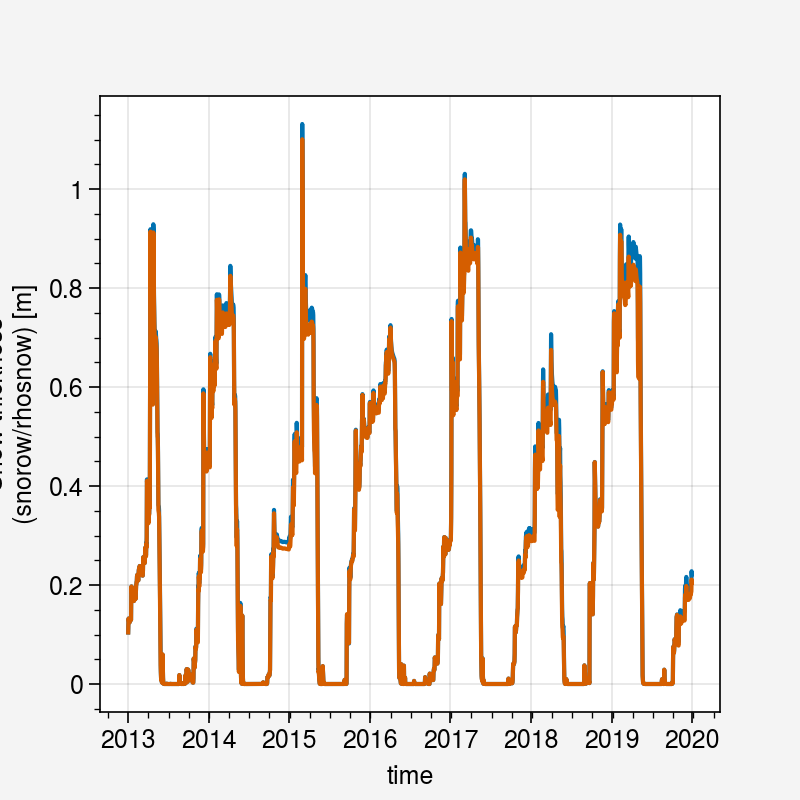

In [40]:
ds_d_SnowMIP_list[0][3].snd.plot()
ds_d_SnowMIP_list[1][3].snd.plot()


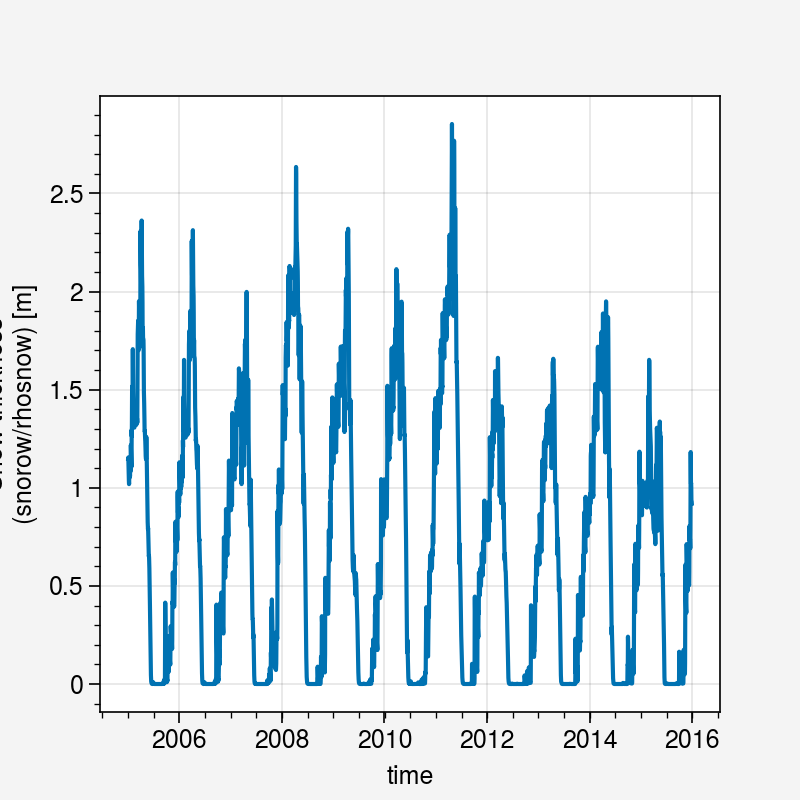

In [36]:
ds_d_SnowMIP_list[1][0].snd.plot()

In [31]:
(ds_d_SnowMIP_list[1][0].snd - ds_d_SnowMIP_list[0][0].snd).mean()

<xarray.DataArray 'snd' ()> Size: 8B
array(-0.02328921)

In [32]:
(ds_d_SnowMIP_list[1][1].snd - ds_d_SnowMIP_list[0][1].snd).mean()

<xarray.DataArray 'snd' ()> Size: 8B
array(-0.00215122)

In [33]:
(ds_d_SnowMIP_list[1][2].snd - ds_d_SnowMIP_list[0][2].snd).mean()

<xarray.DataArray 'snd' ()> Size: 8B
array(-0.01194921)

In [34]:
(ds_d_SnowMIP_list[1][3].snd - ds_d_SnowMIP_list[0][3].snd).mean()

<xarray.DataArray 'snd' ()> Size: 8B
array(-0.00727255)

In [109]:
ds_d_SnowMIP_list[1][3]

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 2556, layer: 20)
Coordinates:
  * time        (time) datetime64[ns] 20kB 2013-01-01 2013-01-02 ... 2019-12-31
  * layer       (layer) float64 160B 0.05 0.15 0.25 0.35 ... 8.9 18.9 41.4 58.9
Data variables: (12/54)
    longitude   float64 8B -133.5
    latitude    float64 8B 68.75
    actlyr      (time) float64 20kB 0.2817 0.2705 0.2609 ... 1.815 1.806 1.797
    albs        (time) float64 20kB 0.7338 0.7716 0.7841 ... 0.8221 0.7923
    albsir      (time) float64 20kB 0.6362 0.6705 0.6801 ... 0.7093 0.6743
    albsn       (time) float64 20kB 0.8354 0.84 0.8357 ... 0.811 0.8244 0.7991
    ...          ...
    tsn         (time) float64 20kB -15.55 -12.86 -11.44 ... -15.52 -14.65
    tsnbot      (time) float64 20kB -11.69 -9.663 -8.342 ... -7.924 -7.475
    vegHeight   (time) float64 20kB 0.1531 0.1525 0.1519 ... 0.1551 0.154 0.1528
    wsnw        (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wtd         (time) float64 20kB 9.999e+03 9.999e+03 ... 9.999e+03 9.999e+03
    zpond       (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        CLASSIC output file
    timestamp:    20250618 1635
    Conventions:  COARDS
    node_offset:  1
    Comment:       run Ref

### SD

In [41]:
exps

['BUG_CORRECT_TSNBT_OP1_EZERO', 'PHYS_ALL_SUBLI_v2']

In [42]:
label_exps = ['PHYS', '+ SUBLI']

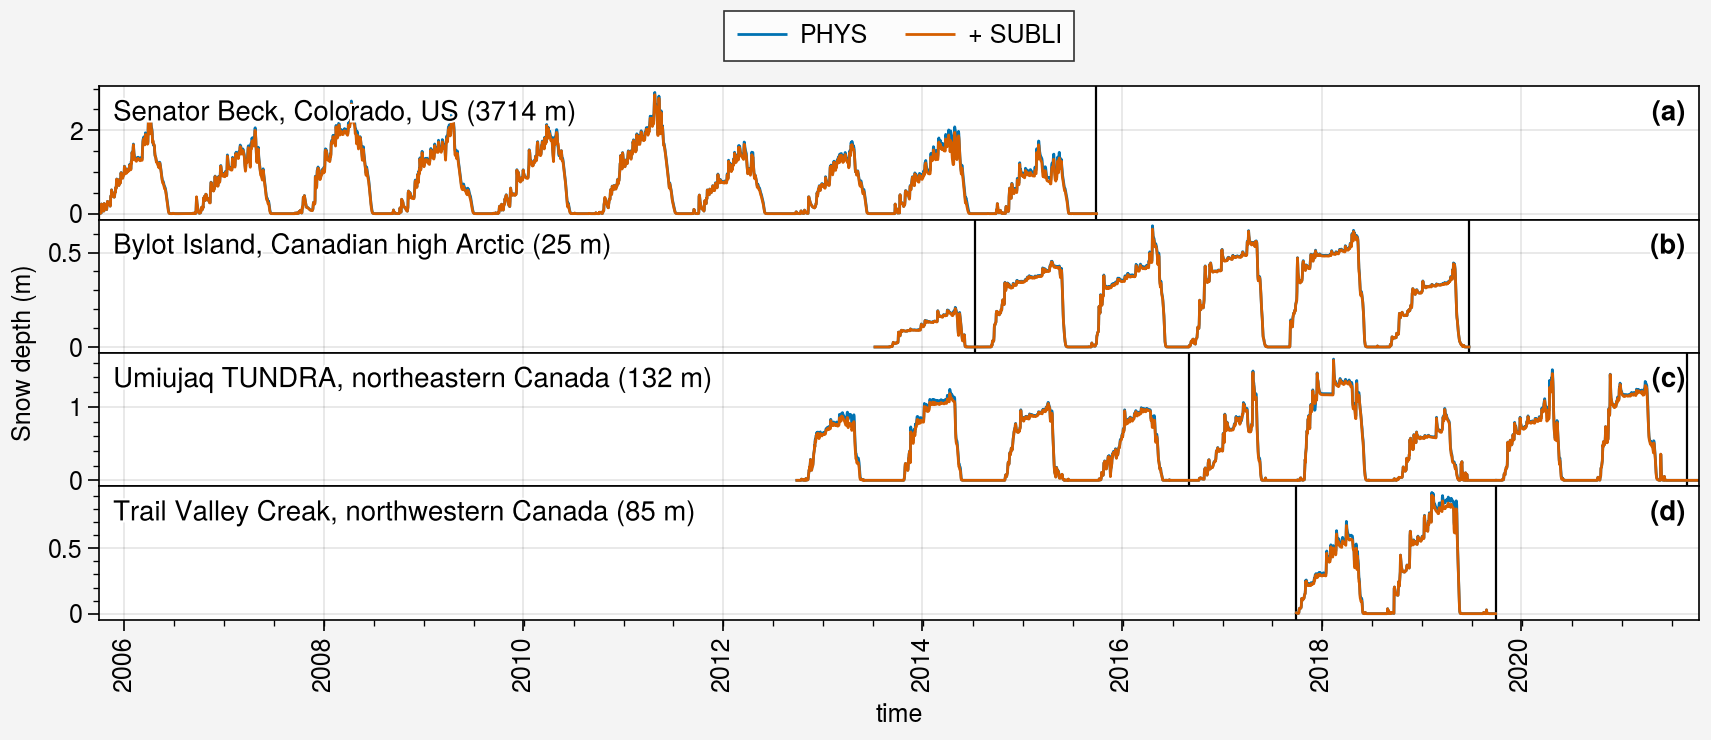

In [45]:
fig, axs = pplt.subplots(nrows=len(SnowMIP_sites+SnowArctic_sites), refaspect=12, refwidth=8, space=0)

color_obs = 'gray8'

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    # Model 
    h_exps = []
    # for j, exp in enumerate(exps): 
    for j, exp in enumerate(label_exps): 
        h = axs[i].plot(ds_d_SnowMIP_list[j][i].snd.sel(time=slice(site.start, site.stop)), label=exp, lw=1)
        h_exps.append(h)

    # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
    #     h_paul = axs[i].plot(ds_d_Paul_list[i].snd.sel(time=slice(site.start, site.stop)), label='CLASS', color='red9', lw=1)

    
    axs[i].format(ylabel='Snow depth (m)', ultitle=site.long_name+' ('+site.elevation+')')
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[0], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[-1], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    


# axs[4].legend(ncols=5, loc='ll')
# fig.legend(h_exps+h_paul+h_obs_auto+h_obs_man, ncols=2, loc='t')
fig.legend(h_exps, ncols=8, loc='t')

fig.format(abc='(a)', abcloc='ur')

# fig.suptitle('Col de Porte, France, 1325 m')
# fig.save('img/tn1_sd_correct_SH.jpg')

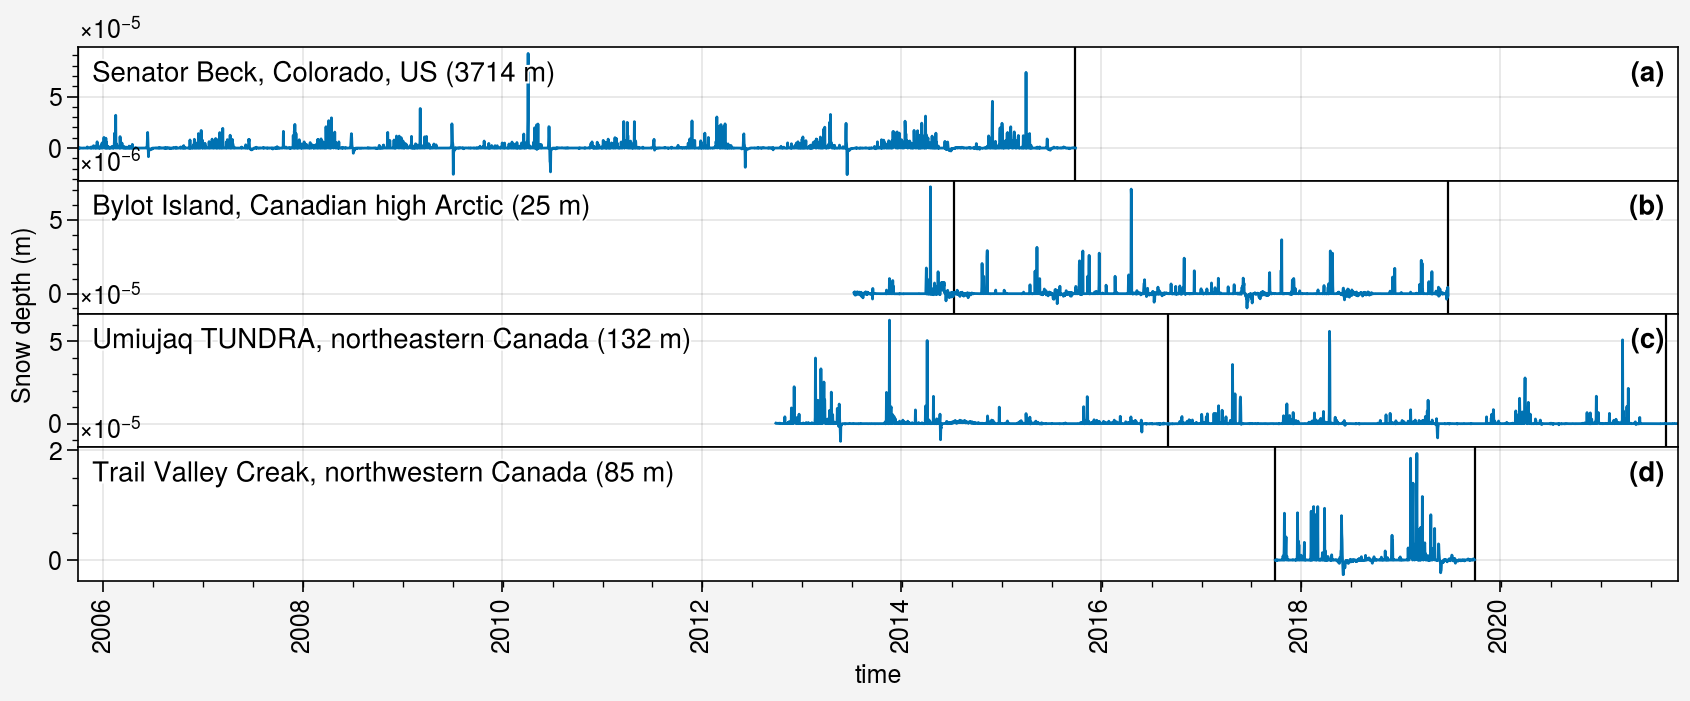

In [122]:
%matplotlib inline
fig, axs = pplt.subplots(nrows=len(SnowMIP_sites+SnowArctic_sites), refaspect=12, refwidth=8, space=0)

color_obs = 'gray8'

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    # Model 
    h_exps = []
    # for j, exp in enumerate(exps): 
    # for j, exp in enumerate(label_exps): 
    #     h = axs[i].plot(ds_d_SnowMIP_list[j][i].evspsbl.sel(time=slice(site.start, site.stop)), label=exp, lw=1)
    #     h_exps.append(h)

    h = axs[i].plot(
        ds_d_SnowMIP_list[1][i].evspsbl.sel(time=slice(site.start, site.stop)) - \
            ds_d_SnowMIP_list[0][i].evspsbl.sel(time=slice(site.start, site.stop))
                   , label=exp, lw=1)
            
    

    # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
    #     h_paul = axs[i].plot(ds_d_Paul_list[i].snd.sel(time=slice(site.start, site.stop)), label='CLASS', color='red9', lw=1)

    
    axs[i].format(ylabel='Snow depth (m)', ultitle=site.long_name+' ('+site.elevation+')')
    axs[i].vlines(ds_d_SnowMIP_list[0][i].sel(time=site.period_used).time[0], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    axs[i].vlines(ds_d_SnowMIP_list[0][i].sel(time=site.period_used).time[-1], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    


# axs[4].legend(ncols=5, loc='ll')
# fig.legend(h_exps+h_paul+h_obs_auto+h_obs_man, ncols=2, loc='t')
# fig.legend(h, ncols=8, loc='t')

fig.format(abc='(a)', abcloc='ur')

# fig.suptitle('Col de Porte, France, 1325 m')
# fig.save('img/tn1_sd_correct_SH.jpg')

In [56]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    print(site.long_name)
    
    for j, exp in enumerate(label_exps): 
        print(ds_d_SnowMIP_list[j][i].snd.sel(time=slice(site.start, site.stop)).mean().values)

    print(
        (ds_d_SnowMIP_list[1][i].snd.sel(time=slice(site.start, site.stop)) -
         ds_d_SnowMIP_list[0][i].snd.sel(time=slice(site.start, site.stop))).mean().values*100)

Senator Beck, Colorado, US
0.7247816649533878
0.7001805316602739
-2.4601133293113784
Bylot Island, Canadian high Arctic
0.2287554502362997
0.22634357648045722
-0.24118737558424833
Umiujaq TUNDRA, northeastern Canada
0.4276342337958045
0.41624536004799834
-1.138887374780616
Trail Valley Creak, northwestern Canada
0.32086823633857464
0.30926374233608495
-1.1604494002489707


In [125]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    print(site.long_name)
    
    for j, exp in enumerate(label_exps): 
        ds0 = ds_d_SnowMIP_list[j][i].snd.sel(time=slice(site.start, site.stop))
        print(ds0.where(ds0 > 0.1).mean().values)

    ds1 = ds_d_SnowMIP_list[1][i].snd.sel(time=slice(site.start, site.stop))
    ds2 = ds_d_SnowMIP_list[0][i].snd.sel(time=slice(site.start, site.stop))
    print((ds1.where(ds1 > 0.1) - ds2.where(ds2 > 0.1)).mean().values*100)

Senator Beck, Colorado, US
1.0799050143960776
1.0493877330557029
-3.639342917419629
Bylot Island, Canadian high Arctic
0.3551301300335656
0.3514125469522712
-0.37175830812943783
Umiujaq TUNDRA, northeastern Canada
0.7684258480280106
0.7510705976126869
-2.0245275535743055
Trail Valley Creak, northwestern Canada
0.5060239530483608
0.4920592537474768
-1.8259498092974447


In [129]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    print(site.long_name)
    
    for j, exp in enumerate(label_exps): 
        tmp = ds_d_SnowMIP_list[j][i].snd.sel(time=slice(site.start, site.stop))
        ds0 = tmp.where(tmp > 0.1).resample(time='1Y').max(dim='time').mean()
        print(ds0.values)

    tmp = ds_d_SnowMIP_list[1][i].snd.sel(time=slice(site.start, site.stop))
    ds1 = tmp.where(tmp > 0.1).resample(time='1Y').max(dim='time').mean()
    
    tmp = ds_d_SnowMIP_list[0][i].snd.sel(time=slice(site.start, site.stop))
    ds2 = tmp.where(tmp > 0.1).resample(time='1Y').max(dim='time').mean()
    
    print((ds1.where(ds1 > 0.1) - ds2.where(ds2 > 0.1)).max().values*100)

Senator Beck, Colorado, US
2.0741497847740304
2.012445374640897
-6.170441013313344
Bylot Island, Canadian high Arctic
0.46424848094487264
0.45828440684359023
-0.5964074101282413
Umiujaq TUNDRA, northeastern Canada
1.1840783058221578
1.1518850487172068
-3.2193257104951023
Trail Valley Creak, northwestern Canada
0.6500391551541487
0.6277068391929627
-2.233231596118601


<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be

In [58]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    print(site.long_name)
    
    for j, exp in enumerate(label_exps): 
        print(ds_d_SnowMIP_list[j][i].snw.sel(time=slice(site.start, site.stop)).mean().values)

    print(
        (ds_d_SnowMIP_list[1][i].snw.sel(time=slice(site.start, site.stop)) -
         ds_d_SnowMIP_list[0][i].snw.sel(time=slice(site.start, site.stop))).mean().values)

Senator Beck, Colorado, US
231.81242272694672
220.5768467780163
-11.235575948930425
Bylot Island, Canadian high Arctic
50.020238119581954
49.37808324756564
-0.6421548720163102
Umiujaq TUNDRA, northeastern Canada
119.15972914457423
115.06439508396481
-4.095334060609417
Trail Valley Creak, northwestern Canada
77.63211288052213
73.8040124253683
-3.8281004551538462


In [ ]:
inputFiles/SnowArctic/tvc/forcing/met_insitu_tvc_30min_ext_2xSnowf2013_2019_Snowf.nc

In [59]:
root_forcing = '/home/lalandmi/eccc/classic-develop/inputFiles/'
path_snb_forcing = root_forcing+'SnowMIP/snb/forcing/met_insitu_snb_30min_ext_2005_2015_Snowf.nc'
path_umt_forcing = root_forcing+'SnowArctic/umt/forcing/met_insitu_umt_30min_ext_2012_2021_Snowf.nc'
path_tvc_forcing = root_forcing+'SnowArctic/tvc/forcing/met_insitu_tvc_30min_ext_2xSnowf2013_2019_Snowf.nc'

In [63]:
path_pwd = '/home/lalandmi/github/SnowC2/CLASSIC/in_situ'

In [64]:
# !cdo -r -f nc copy {path_snb_forcing} {path_pwd}/met_insitu_snb_30min_ext_2005_2015_Snowf_rel.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 192816 values from 1 variable over 192816 timesteps [2.92s 350MB]


In [69]:
# !cdo -r -f nc copy {path_umt_forcing} {path_pwd}/met_insitu_umt_30min_ext_2012_2021_Snowf_rel.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 175344 values from 1 variable over 175344 timesteps [2.72s 354MB]


In [68]:
# !cdo -r -f nc copy {path_tvc_forcing} {path_pwd}/met_insitu_tvc_30min_ext_2xSnowf2013_2019_Snowf_rel.nc

cdo    copy:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    copy: Processed 122640 values from 1 variable over 122640 timesteps [1.94s 354MB]


In [74]:
snf_snb.Snowf

<xarray.DataArray 'Snowf' (time: 192816, lat: 1, lon: 1)> Size: 2MB
[192816 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2MB 2005-01-01 ... 2015-12-31T23:30:00
  * lon      (lon) float64 8B -107.7
  * lat      (lat) float64 8B 37.91
Attributes:
    long_name:  Snowfall rate
    units:      kg/m2/s
    ALMA_name:  Snowf
    CMIP_name:  prsn

In [76]:
snf_snb = xr.open_dataset('met_insitu_snb_30min_ext_2005_2015_Snowf_rel.nc')
snf_snb = snf_snb.Snowf.sel(time=slice(snb.start, snb.stop))
                            
snf_umt = xr.open_dataset('met_insitu_umt_30min_ext_2012_2021_Snowf_rel.nc')
snf_umt = snf_umt.Snowf.sel(time=slice(umt.start, umt.stop))

snf_tvc = xr.open_dataset('met_insitu_tvc_30min_ext_2xSnowf2013_2019_Snowf_rel.nc')
snf_tvc = snf_tvc.Snowf.sel(time=slice(tvc.start, tvc.stop))


In [78]:
snf_snb.mean()

<xarray.DataArray 'Snowf' ()> Size: 8B
array(2.79785245e-05)

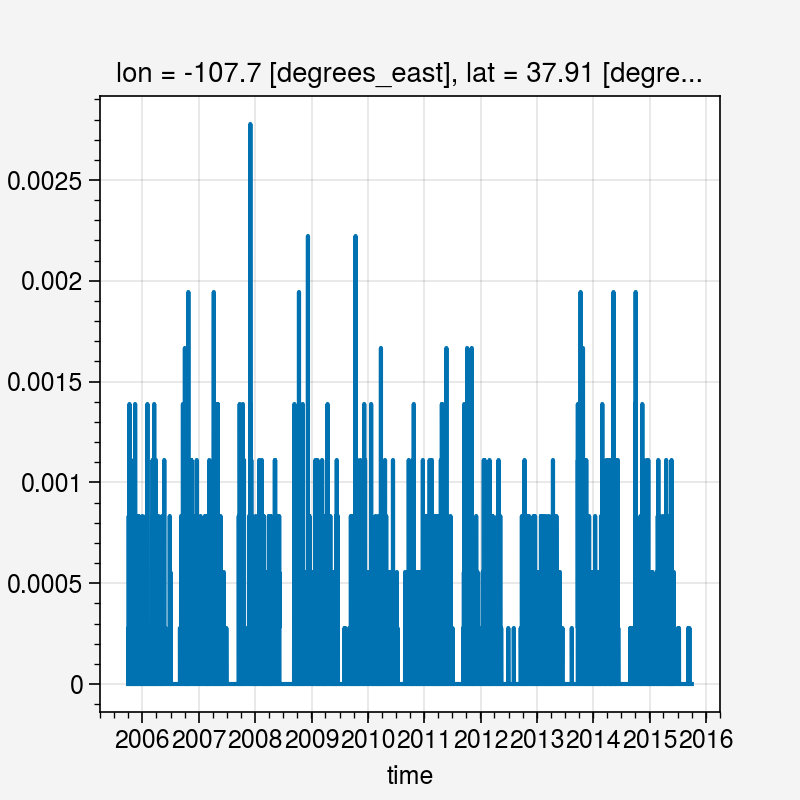

In [87]:
snf_snb.plot()

In [99]:
ds_d_SnowMIP_list[1][0].snw.sel(time=slice(snb.start, snb.stop)).resample(time='1Y').mean(dim='time') - \
ds_d_SnowMIP_list[0][0].snw.sel(time=slice(snb.start, snb.stop)).resample(time='1Y').mean(dim='time')

<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


<xarray.DataArray 'snw' (time: 11)> Size: 88B
array([ -0.93542556,  -6.96942749,  -9.53554576, -12.93694871,
       -11.97359589,  -7.27130457,  -8.84544254,  -7.97558393,
        -9.22055642, -20.65461913, -22.38295882])
Coordinates:
  * time     (time) datetime64[ns] 88B 2005-12-31 2006-12-31 ... 2015-12-31

In [101]:
ds_d_SnowMIP_list[1][0].snw.sel(time=slice(snb.start, snb.stop)).resample(time='1Y').max(dim='time') - \
ds_d_SnowMIP_list[0][0].snw.sel(time=slice(snb.start, snb.stop)).resample(time='1Y').max(dim='time')

<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


<xarray.DataArray 'snw' (time: 11)> Size: 88B
array([ -2.80620704, -16.53882659, -25.95290268, -32.23390301,
       -25.87311862, -27.22575825, -26.16885178, -22.3264984 ,
       -30.8584894 , -61.1354722 , -43.70524886])
Coordinates:
  * time     (time) datetime64[ns] 88B 2005-12-31 2006-12-31 ... 2015-12-31

In [94]:
snf_snb.resample(time='1Y').sum(dim='time') * 1800



<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


<xarray.DataArray 'Snowf' (time: 11, lat: 1, lon: 1)> Size: 88B
array([[[ 303.25170122]],

       [[ 883.75431974]],

       [[ 907.00486586]],

       [[1100.00647944]],

       [[ 857.11062327]],

       [[ 965.00604954]],

       [[1033.00597994]],

       [[ 599.00210202]],

       [[ 773.00001872]],

       [[ 928.00002247]],

       [[ 479.0000116 ]]])
Coordinates:
  * lon      (lon) float64 8B -107.7
  * lat      (lat) float64 8B 37.91
  * time     (time) datetime64[ns] 88B 2005-12-31 2006-12-31 ... 2015-12-31

In [108]:
for i, (site, snf) in enumerate(zip(SnowMIP_sites+SnowArctic_sites[1:], [snf_snb, snf_umt, snf_tvc])):
    print(site.long_name)
    
    for j, exp in enumerate(label_exps): 
        print(ds_d_SnowMIP_list[j][i].snw.sel(time=slice(site.start, site.stop)).mean().values)

    print(
        (ds_d_SnowMIP_list[1][i].snw.sel(time=slice(site.start, site.stop)) -
         ds_d_SnowMIP_list[0][i].snw.sel(time=slice(site.start, site.stop))).mean().values)

    snf_y = snf.resample(time='1Y').sum(dim='time') * 1800
    
    max_swe_diff_y = ds_d_SnowMIP_list[1][i].snw.sel(time=slice(snb.start, snb.stop)).resample(time='1Y').max(dim='time') - \
        ds_d_SnowMIP_list[0][i].snw.sel(time=slice(snb.start, snb.stop)).resample(time='1Y').max(dim='time')

    f_subli_y = max_swe_diff_y / snf_y
    print(f_subli_y.mean().values*100)


Senator Beck, Colorado, US
231.81242272694672
220.5768467780163
-11.235575948930425
-3.672110095542686
Umiujaq TUNDRA, northeastern Canada
47.76263316903874
47.1788268471953
-0.5838063218434449
-0.3266578871211239
Trail Valley Creak, northwestern Canada
142.51895870503
138.8340078722938
-3.6849508327361935
nan


<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
<string>:6: FutureWarning: 'Y' is deprecated and will be